In [1]:
import celltypist
from celltypist import models

In [2]:
import scanpy as sc
import celltypist
import time
import numpy as np

In [9]:
import pandas as pd

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [12]:
def plot_confusion_matrix(confm, true_labels, all_labels, title, size=20, with_text=True):
    """
    Plot a confusion matrix.

    Parameters:
    - confm: Original confusion matrix
    - true_labels: List of true labels
    - all_labels: List of all labels in the order they appear in confm
    - title: Title of the plot
    - size: Size of the plot
    - with_text: Whether to include text in the cells
    """
    plt.figure(figsize=(size, size))

    # Extract relevant rows based on true labels
    confm_selected = cm[[labels.index(lab) for lab in true_labels]]

    # Normalize
    confm_selected = confm_selected.astype('float') / (confm_selected.sum(axis=1)[:, np.newaxis] + 1e-9)
    confm_selected = np.around(confm_selected, 4)

    ax = plt.subplot(1, 1, 1)
    plt.imshow(confm_selected, interpolation='nearest', cmap='Blues')

    if with_text:
        for i in range(len(confm_selected)):
            for j in range(len(confm_selected[0])):
                color = 'w' if confm_selected[i, j] > 0.5 else 'black'
                plt.text(j, i, confm_selected[i, j], ha="center", va="center", color=color)

    plt.title(title)
    plt.xticks(np.arange(len(all_labels)), all_labels, rotation=90)
    plt.yticks(np.arange(len(true_labels)), true_labels, rotation=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

In [29]:
from sklearn.metrics import confusion_matrix

# Load reference data

In [6]:
adata = sc.read_h5ad("/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/eca_heart_liver_lung_blood_bm.h5ad")
adata

AnnData object with n_obs × n_vars = 5658677 × 42117
    obs: 'study_id', 'donor_gender', 'cell_type', 'organ', 'age_bin', 'donor_age', 'region', 'seq_tech'

In [ ]:
# Select 2,000 HVGs
gene_list = pd.read_csv("gene_list.csv")['gene_name']
adata = adata[:,gene_list]

In [ ]:
# Get the total number of cells
n_cells = adata.shape[0]

# Shuffle the cell order 
np.random.seed(0)
indices = np.random.permutation(n_cells)
adata = adata[indices[:200000]]


n_cells = adata.shape[0]
indices = np.random.permutation(n_cells)
n_train = int(0.8 * n_cells)

# Split the data with 8:2
adata_train = adata[indices[:n_train]]
adata_test = adata[indices[n_train:]]

In [16]:
adata_train.obs.organ.value_counts()

organ
Lung            70416
Blood           29522
Heart           25706
Liver           17133
Bone marrow     16793
Thymus            410
Unclassified       20
Name: count, dtype: int64

In [17]:
adata_test.obs.organ.value_counts()

organ
Lung            17479
Blood            7433
Heart            6406
Liver            4344
Bone marrow      4227
Thymus            108
Unclassified        3
Name: count, dtype: int64

# Train model

In [18]:
t_start = time.time()
model_fs = celltypist.train(adata_train, 'cell_type', n_jobs = 50, max_iter = 100,check_expression = False)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🍳 Preparing data before training
🔬 Input data has 160000 cells and 2000 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


Time elapsed: 502.7297284603119 seconds


NameError: name 'model' is not defined

In [19]:
model_fs.write('/nfs/public/cell_gpt_data/Test_data/celltypist_model/multiorgan.1031.pkl')

# Validation

In [20]:
t_start = time.time()
predictions = celltypist.annotate(adata_test, model = '/nfs/public/cell_gpt_data/Test_data/celltypist_model/multiorgan.1031.pkl', majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🔎 No available models. Downloading...
📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in /home/chenyx/.celltypist/data/models
💾 Downloading model [1/44]: Immune_All_Low.pkl
💾 Downloading model [2/44]: Immune_All_High.pkl
💾 Downloading model [3/44]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [4/44]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [5/44]: Adult_Human_Skin.pkl
💾 Downloading model [6/44]: Adult_Mouse_Gut.pkl
💾 Downloading model [7/44]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [8/44]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [9/44]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [10/44]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [11/44]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [12/44]: COVID19_Immune_Landscape.pkl
💾 Downloading model [13/44]: Cells_Fetal_Lung.pkl
💾 Downloading model [14/44]: Cells_Intestinal_Tract.pkl
💾 Downloadi

Time elapsed: 186.05442309379578 seconds


In [28]:
predictions

CellTypist prediction result for 40000 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 40000 query cells and 95 cell types
    probability_matrix: data frame with 40000 query cells and 95 cell types
    adata: AnnData object referred

<Figure size 2000x2000 with 0 Axes>

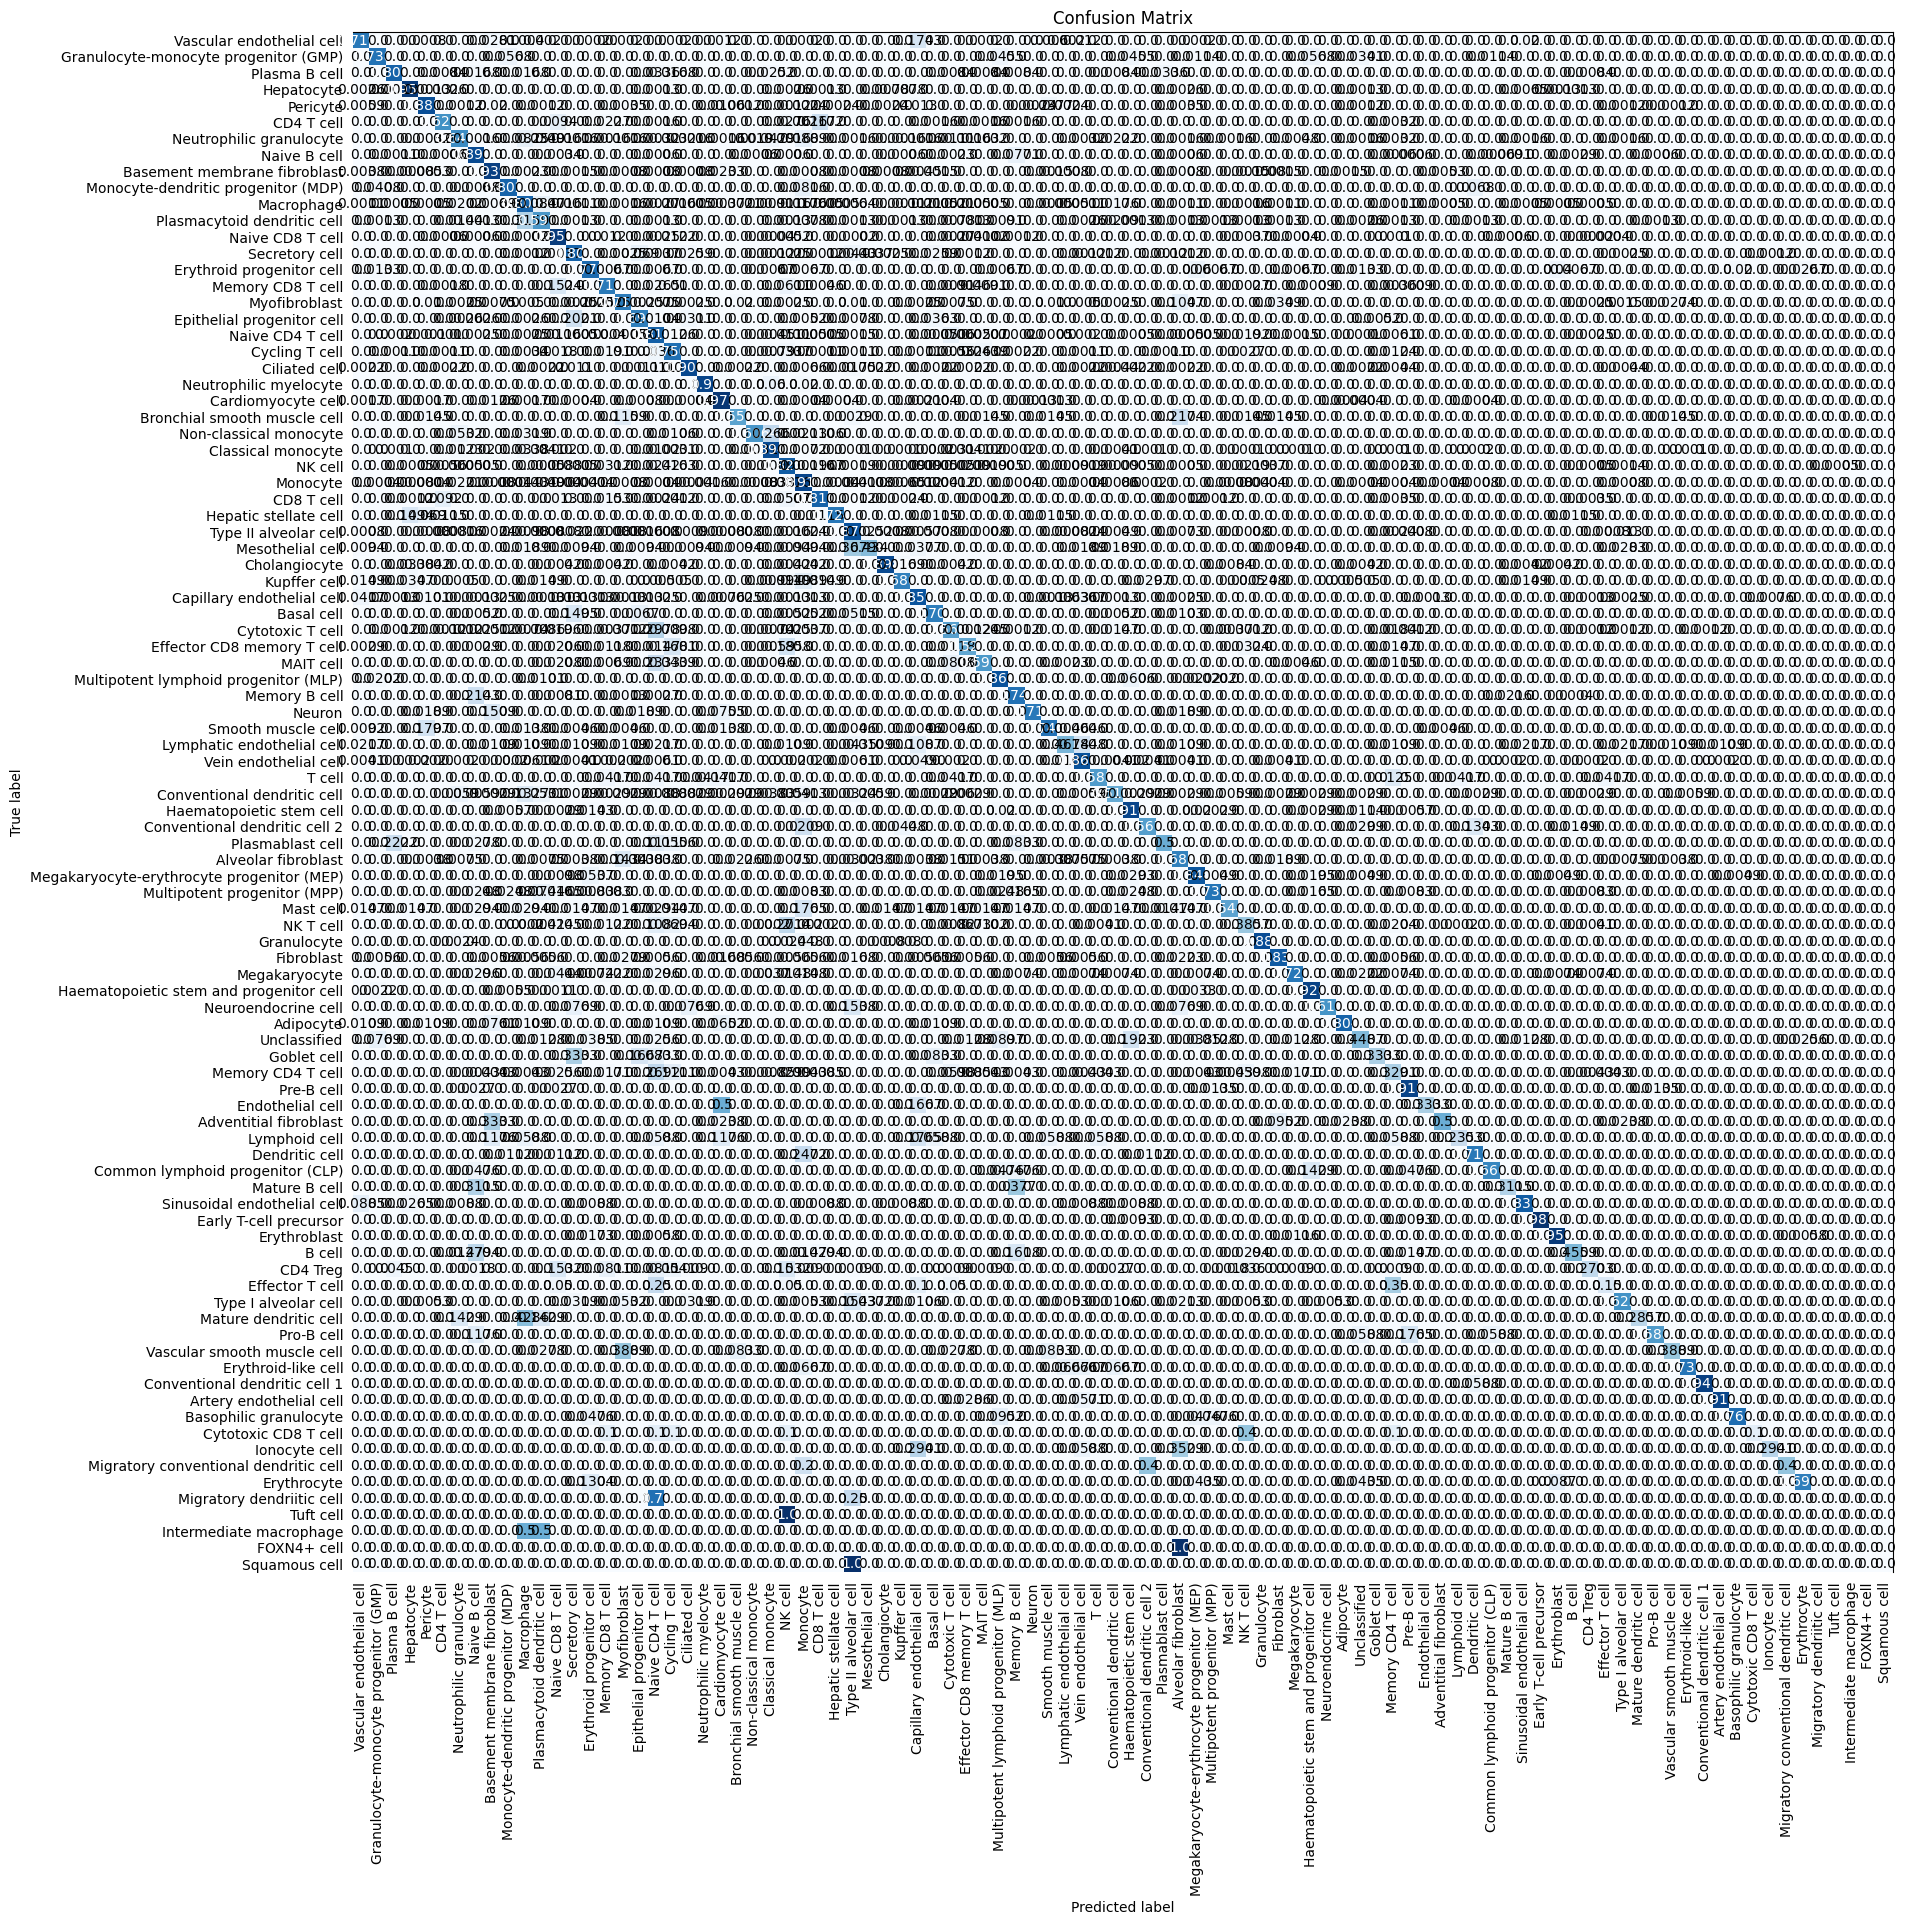

In [34]:
targets_ = list(adata_test.obs.cell_type.astype(str))
preds_ = list(predictions.predicted_labels.predicted_labels)
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())
cm = confusion_matrix(targets_, preds_, labels=labels)
plt.figure(figsize=(20, 20))
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix")

# Test

## Simonson 2023

In [ ]:
adata_test = sc.read_h5ad("/nfs/public/cell_gpt_data/Test_data/Heart/Simonson.h5ad")
adata_test = adata_test[:,gene_list]

In [66]:
adata_test

View of AnnData object with n_obs × n_vars = 60345 × 2000
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id'
    uns: 'log1p'

In [67]:
t_start = time.time()
predictions = celltypist.annotate(adata_test, model = '/nfs/public/cell_gpt_data/Test_data/celltypist_model/multiorgan.1031.pkl', majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 60345 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 2000 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


Time elapsed: 96.35278630256653 seconds


In [ ]:
targets_ = list(adata_test.obs.cell_type2.astype(str))
preds_ = list(predictions.predicted_labels.predicted_labels)

df_result = pd.DataFrame({"predictions":preds_,"labels":targets_})
df_result.index = adata_test.obs.index
df_result.to_csv("Celltypist_Anno_Result/Heart/Simonson.csv")

## Suo2022

In [85]:
adata_test = sc.read_h5ad("/nfs/public/cell_gpt_data/Test_data/Liver/Liver_test.h5ad")

In [ ]:
adata_test = adata_test[:,gene_list]

In [87]:
adata_test

View of AnnData object with n_obs × n_vars = 137181 × 2000
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id'
    uns: 'log1p'

In [88]:
t_start = time.time()
predictions = celltypist.annotate(adata_test, model = '/nfs/public/cell_gpt_data/Test_data/celltypist_model/multiorgan.1031.pkl', majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 137181 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 2000 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


Time elapsed: 183.53330540657043 seconds


In [ ]:
targets_ = list(adata_test.obs.cell_type2.astype(str))
preds_ = list(predictions.predicted_labels.predicted_labels)

df_result = pd.DataFrame({"predictions":preds_,"labels":targets_})
df_result.index = adata_test.obs.index
df_result.to_csv("Celltypist_Anno_Result/Liver/Testset1.csv")

## AHCA Bonemarrow

In [92]:
adata_test = sc.read_h5ad("/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/bone_marrow_AHCA_uniformed.h5ad")
sc.pp.normalize_total(adata_test,target_sum=1e4)
sc.pp.log1p(adata_test)

In [93]:
adata_test = adata_test[:,gene_list]

In [94]:
adata_test.obs['cell_type2'] = "Unclassified"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['CD4 T Cell IL7R_high Marrow', ])] = "CD4 T cell"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['B Cell Marrow'])] = "B cell"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['NK/T Cell GNLY_high Marrow', 'NK/T Cell PTGDS_high Marrow'])] = "NK T cell"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['T Cell Marrow', 'T GD Cell TRDV2_high Marrow','T GD Cell TRDV1_high Marrow'])] = "T cell"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['CD8 T Cell RGS1_high Marrow', 'CD8 T Cell TRBV4-2_high Marrow',  'CD8 T Cell TRBV4-1_high Marrow','CD8 T Cell TRAV14DV4_high Marrow'])] = "CD8 T cell"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['Macrophage/Monocyte Marrow', ])] = "Macrophage"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['Plasma Cell JCHAIN_high Marrow'])] = "Plasma cell"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['High Proliferation Erythrocyte Marrow'])] = "Erythrocyte"
adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['Multiple Progenitor Marrow'])] = "Multipotent hematopoietic progenitor"

/tmp/ipykernel_4078390/3757348728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['CD4 T Cell IL7R_high Marrow', ])] = "CD4 T cell"
/tmp/ipykernel_4078390/3757348728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_test.obs['cell_type2'][adata_test.obs.Cell_type_in_each_tissue.isin(['B Cell Marrow'])] = "B cell"
/tmp/ipykernel_4078390/3757348728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [95]:
t_start = time.time()
predictions = celltypist.annotate(adata_test, model = '/nfs/public/cell_gpt_data/Test_data/celltypist_model/multiorgan.1031.pkl', majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 3230 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 2000 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Time elapsed: 1.72847318649292 seconds


In [ ]:
targets_ = list(adata_test.obs.cell_type2.astype(str))
preds_ = list(predictions.predicted_labels.predicted_labels)

df_result = pd.DataFrame({"predictions":preds_,"labels":targets_})
df_result.index = adata_test.obs.index
df_result.to_csv("Celltypist_Anno_Result/BoneMarrow/AHCA.csv")